<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Using Quantus Evaluation with DIANNA
This notebook demonstrates the use of [Quantus](https://github.com/understandable-machine-intelligence-lab/Quantus) with the use of DIANNA's explanation methods. <br> We will demonstrate the necessary input and output constraints and postprocessing that is necessary to ensure integration between the two libraries. 

In [23]:
import warnings
warnings.filterwarnings('ignore') # disable warnings relateds to versions of tf
import numpy as np
import dianna
import onnx
import quantus

from metrics import Incremental_deletion
from utils import * # Imports utilities for quantus compatability

from onnx_tf.backend import prepare
import matplotlib.pyplot as plt
from pathlib import Path

### 1 - Loading in the MNIST dataset

In [24]:
# # load dataset
data = np.load(Path().absolute().parent / 'data/binary-mnist.npz')
# load testing data and the related labels
X_test = data['X_test'].astype(np.float32).reshape([-1, 28, 28, 1]) / 255

In [25]:
# Load saved onnx model
onnx_model_path = Path('../models', 'mnist_model_tf.onnx')
onnx_model = onnx.load(onnx_model_path)
# get the output node
output_node = prepare(onnx_model, gen_tensor_dict=True).outputs[0]

The predicted class is: digit 0


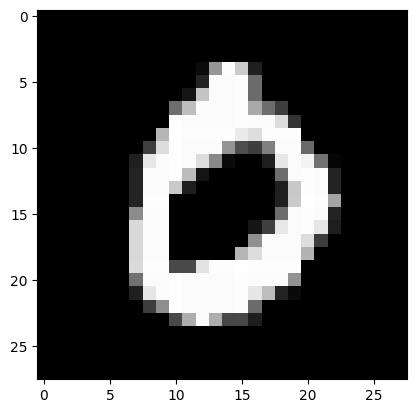

In [26]:
# class name
class_name = ['digit 0', 'digit 1']
# instance index
i_instance = 1
# select instance for testing
test_sample = X_test[i_instance].copy().astype(np.float32)
# model predictions with added batch axis to test sample
predictions = prepare(onnx_model).run(test_sample[None, ...])[f'{output_node}']
pred_class = class_name[np.argmax(predictions)]
print("The predicted class is:", pred_class)
plt.imshow(X_test[i_instance][:,:,0], cmap='gray')  # 0 for channel

### 2 - Batching the input 

Quantus requires batched input variables, which we introduce here. 

In [32]:
x_batch = test_sample[np.newaxis, ...]
y_batch = np.array([0])

x_batch.shape

(1, 28, 28, 1)

### 3 - Checking available methods

Below we display all the available methods in quantus

In [33]:
quantus.helpers.constants.available_categories()

['Faithfulness',
 'Robustness',
 'Localisation',
 'Complexity',
 'Randomisation',
 'Axiomatic']

In [34]:
quantus.helpers.constants.available_metrics()

{'Faithfulness': ['Faithfulness Correlation',
  'Faithfulness Estimate',
  'Pixel-Flipping',
  'Region Segmentation',
  'Monotonicity-Arya',
  'Monotonicity-Nguyen',
  'Selectivity',
  'SensitivityN',
  'IROF',
  'ROAD',
  'Infidelity',
  'Sufficiency'],
 'Robustness': ['Continuity Test',
  'Local Lipschitz Estimate',
  'Max-Sensitivity',
  'Avg-Sensitivity',
  'Consistency',
  'Relative Input Stability',
  'Relative Output Stability',
  'Relative Representation Stability'],
 'Localisation': ['Pointing Game',
  'Top-K Intersection',
  'Relevance Mass Accuracy',
  'Relevance Rank Accuracy',
  'Attribution Localisation ',
  'AUC',
  'Focus'],
 'Complexity': ['Sparseness', 'Complexity', 'Effective Complexity'],
 'Randomisation': ['Model Parameter Randomisation', 'Random Logit'],
 'Axiomatic': ['Completeness', 'NonSensitivity', 'InputInvariance']}

### 4 - ONNX to Keras

This is an experimental feature so keep in mind to **USE THIS WITH CARE**. This conversion requires the input names defined before pickling the model. <br> I have included a helper function that reads this name from the onnx_model as `get_onnx_names`. We then leverage the `onnx_to_keras` library that does the heavy lifting of conversion for us. 

In [50]:
from onnx2keras import onnx_to_keras

feed_net_input, output = get_onnx_names(onnx_model)
k_model = onnx_to_keras(onnx_model, net_feed_input, name_policy='renumerate', verbose=False)

Unable to use `same` padding. Add ZeroPadding2D layer to fix shapes.
Failed to use keras.layers.Add. Fallback to TF lambda.
Failed to use keras.layers.Add. Fallback to TF lambda.


Tensor("Placeholder:0", shape=(None, 128), dtype=float32) Tensor("Placeholder_1:0", shape=(128,), dtype=float32)
Tensor("Placeholder:0", shape=(None, 2), dtype=float32) Tensor("Placeholder_1:0", shape=(2,), dtype=float32)


### 5 - Using the metrics!

Finally, we show how to use some of the metrics. Keep in mind that the integration between the two libraries is not particularly stable and therefore not all of the afformentioned metrics work. <br> Aditionally, it is vital to use the postprocess functions in order for the metrics to work. 

In [49]:
# Average Sensitivity: KernelSHAP
quantus.AvgSensitivity(
    nr_samples=5,
    perturb_func=quantus.perturb_func.gaussian_noise,
)(model=k_model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,   
   explain_func=SHAP_postprocess, 
   explain_func_kwargs={'model_or_function': onnx_model_path,
                        "input_data": test_sample,
                        "labels": range(1),
                       }
)

Warnings and information:
 (1) The Avg Sensitivity metric is likely to be sensitive to the choice of amount of noise added 'lower_bound' and 'upper_bound', the number of samples iterated over 'nr_samples', the function to perturb the input 'perturb_func', the similarity metric 'similarity_func' as well as norm calculations on the numerator and denominator of the sensitivity equation i.e., 'norm_numerator' and 'norm_denominator'.  
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Yeh, Chih-Kuan, et al. 'On the (in) fidelity and sensitivity for explanations.' arXiv preprint arXiv:1901.09392 (2019).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the met

100%|██████████| 1/1 [00:03<00:00,  3.79s/it]


[0.002556783560096721]

In [51]:
# Average Sensitivity: LIME
quantus.AvgSensitivity(
    nr_samples=5,
    perturb_func=quantus.perturb_func.gaussian_noise,
)(model=k_model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,   
   explain_func=LIME_postprocess, 
   explain_func_kwargs={'model_or_function': onnx_model_path,
                        "input_data": test_sample,
                        "labels": range(1),
                       }
)

Warnings and information:
 (1) The Avg Sensitivity metric is likely to be sensitive to the choice of amount of noise added 'lower_bound' and 'upper_bound', the number of samples iterated over 'nr_samples', the function to perturb the input 'perturb_func', the similarity metric 'similarity_func' as well as norm calculations on the numerator and denominator of the sensitivity equation i.e., 'norm_numerator' and 'norm_denominator'.  
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Yeh, Chih-Kuan, et al. 'On the (in) fidelity and sensitivity for explanations.' arXiv preprint arXiv:1901.09392 (2019).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the met

 95%|█████████▌| 4774/5000 [00:07<00:00, 683.47it/s]

In [ ]:
# Average Sensitivity: RISE
quantus.AvgSensitivity(
    nr_samples=5,
    perturb_func=quantus.perturb_func.gaussian_noise,
)(model=k_model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,   
   explain_func=dianna.explain_image, 
   explain_func_kwargs={'model_or_function': onnx_model_path,
                        "input_data": test_sample,
                        "method": "RISE",
                        "labels": range(1),
                       }
)